# Stock market prediction using Stacked LSTM
## Using KERAS


STEPS :
1. Collection of Data
2. Preprocessing DATA as train dev test
3. Create An stacked LSTM Model
4. predict Test and dev by Graph analysis as ARIMA
5. Predict the forecast

In [227]:
import pandas_datareader as pdr

In [228]:
df = pdr.get_data_tiingo("AAPL",api_key=key) # 'Company name',key,tiingo api key in str format ....minimum request is 50

In [229]:
df.head()

close     high     low    open    volume  \
symbol date                                                                    
AAPL   2015-05-28 00:00:00+00:00  131.780  131.950  131.10  131.86  30733309   
       2015-05-29 00:00:00+00:00  130.280  131.450  129.90  131.23  50884452   
       2015-06-01 00:00:00+00:00  130.535  131.390  130.05  131.20  32112797   
       2015-06-02 00:00:00+00:00  129.960  130.655  129.32  129.86  33667627   
       2015-06-03 00:00:00+00:00  130.120  130.940  129.90  130.66  30983542   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
AAPL   2015-05-28 00:00:00+00:00  121.438354  121.595013  120.811718   
       2015-05-29 00:00:00+00:00  120.056069  121.134251  119.705890   
       2015-06-01 00:00:00+00:00  120.291057  121.078960  119.844118   
       2015-06-02 00:00:00+00:00  119.761181  120.401640  119.171406   
       2015-06-03 00:00:00+00:00  119.908625  120.664274  119.705890   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
AAPL   2015-05-28 00:00:00+00:00  121.512076   30733309      0.0          1.0  
       2015-05-29 00:00:00+00:00  120.931516   50884452      0.0          1.0  
       2015-06-01 00:00:00+00:00  120.903870   32112797      0.0          1.0  
       2015-06-02 00:00:00+00:00  119.669029   33667627      0.0          1.0  
       2015-06-03 00:00:00+00:00  120.406248   30983542      0.0          1.0

In [230]:
df2 = df.reset_index()['close'] # done for closed 

In [231]:
df2.head()

0    131.780
1    130.280
2    130.535
3    129.960
4    130.120
Name: close, dtype: float64

In [232]:
df2.shape

(1257,)

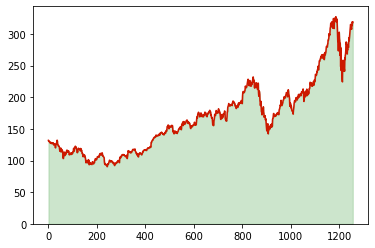

In [233]:
df2.plot(color='r')
df2.plot(kind='area',color='g',alpha=0.2)

In [234]:
import numpy as np

LSTM IS SENSITIVE TO SCALING OF DATA, HERE DATA IS CLOSED (USING MINMAX SCALER)

In [235]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2s = scaler.fit_transform(np.array(df2).reshape(-1,1))

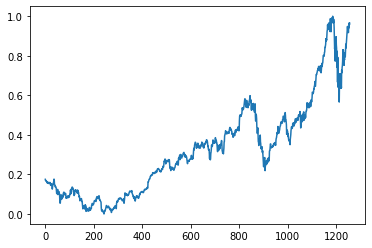

In [236]:
import matplotlib.pyplot as plt
plt.plot(df2s)

It is Time Series problem 

In [237]:
training_size = int(len(df2)*0.65)
test_size = int(len(df)-training_size)
train_data,test_data=df2s[0:training_size,:],df2s[training_size:len(df2s),:1]

In [238]:
training_size,train_data.shape,test_size,test_data.shape

(817, (817, 1), 440, (440, 1))

# Data Preprocessing for LSTM

Time stamp =3
f1 f2 f3 = o/p |||
1  2   3 = 4 ||| 2  3   4 = 5
||| x_train  = y_train

# Hyper parameter Tuning

In [239]:
def create_dataset(data,time_step=1):
    datax,datay=[],[]
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0] #0 1 2 3
        datax.append(a)
        datay.append(data[i+time_step,0])
    return np.array(datax),np.array(datay)

In [240]:
time_step=100 #more time_step is good
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [241]:
X_train.shape,y_train.shape

((716, 100), (716,))

# FOR LSTM RESHAPE DATA TO 3D

In [242]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# LSTM MODEL

In [243]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [244]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # becaues X_train shape[1] = 100,1 
model.add(LSTM(50,return_sequences=True)) # stacked
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [245]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [246]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 3s 260ms/step - loss: 0.0182 - val_loss: 0.0668
Epoch 2/100
12/12 [==============================] - 2s 178ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 3/100
12/12 [==============================] - 2s 184ms/step - loss: 9.2954e-04 - val_loss: 0.0058
Epoch 4/100
12/12 [==============================] - 2s 181ms/step - loss: 7.5123e-04 - val_loss: 0.0040
Epoch 5/100
12/12 [==============================] - 2s 184ms/step - loss: 6.6507e-04 - val_loss: 0.0039
Epoch 6/100
12/12 [==============================] - 2s 183ms/step - loss: 6.4006e-04 - val_loss: 0.0039
Epoch 7/100
12/12 [==============================] - 2s 189ms/step - loss: 6.4854e-04 - val_loss: 0.0043
Epoch 8/100
12/12 [==============================] - 2s 197ms/step - loss: 6.3587e-04 - val_loss: 0.0041
Epoch 9/100
12/12 [==============================] - 2s 189ms/step - loss: 6.0999e-04 - val_loss: 0.0043
Epoch 10/100
12/12 [==============================] - 2s 183ms/

12/12 [==============================] - 2s 202ms/step - loss: 2.0980e-04 - val_loss: 0.0012
Epoch 79/100
12/12 [==============================] - 3s 224ms/step - loss: 2.3084e-04 - val_loss: 0.0019
Epoch 80/100
12/12 [==============================] - 3s 212ms/step - loss: 2.1521e-04 - val_loss: 9.8492e-04
Epoch 81/100
12/12 [==============================] - 2s 205ms/step - loss: 1.9089e-04 - val_loss: 0.0012
Epoch 82/100
12/12 [==============================] - 2s 191ms/step - loss: 1.8774e-04 - val_loss: 0.0010
Epoch 83/100
12/12 [==============================] - 2s 199ms/step - loss: 1.9377e-04 - val_loss: 0.0012
Epoch 84/100
12/12 [==============================] - 2s 195ms/step - loss: 1.7233e-04 - val_loss: 9.4610e-04
Epoch 85/100
12/12 [==============================] - 2s 191ms/step - loss: 1.7370e-04 - val_loss: 0.0013
Epoch 86/100
12/12 [==============================] - 2s 194ms/step - loss: 1.8255e-04 - val_loss: 0.0011
Epoch 87/100
12/12 [==============================]

In [247]:
train_predict= model.predict(X_train)
test_predict = model.predict(X_test)

In [248]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [255]:
#CalCULATE RMSE
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train,train_predict))
#len(train_predict),len(test_predict)

141.90094477274874

1257


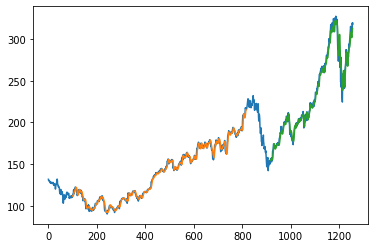

In [283]:
look_back=100 #becaues time_step=100
trainpredictplot = np.empty_like(df2s)
trainpredictplot[:,:] = np.nan

trainpredictplot[look_back:len(train_predict)+look_back,:]=train_predict

testpredictplot = np.empty_like(df2s)
testpredictplot[:,:]=np.nan
print(len(testpredictplot))
testpredictplot[len(train_predict)+(look_back*2)+1:len(df2s)-1,:]=test_predict
plt.plot(scaler.inverse_transform(df2s))
plt.plot(trainpredictplot)
plt.plot(testpredictplot)

# Forecasting 

In [284]:
x_input = test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [285]:
temp_input = x_input[0].tolist()
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

# Logic

In [286]:
n_steps=100
i=0
days =30
lst_output=[]
while(i<days):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:]).reshape(1,-1).reshape((1,n_steps,1)) # reshape made as above for LSTM 3D
        yhat = model.predict(x_input,verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i+=1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i+=1
        

In [287]:
len(lst_output)
#lst_output

30

In [288]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)


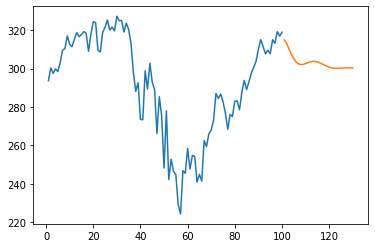

In [290]:
plt.plot(day_new,df2[len(df2)-100:])
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [291]:
df3=[]
df3.extend(df2.tolist())
df3.extend(scaler.inverse_transform(lst_output).reshape(1,-1)[0].tolist())
len(df3),len(df2)

(1287, 1257)

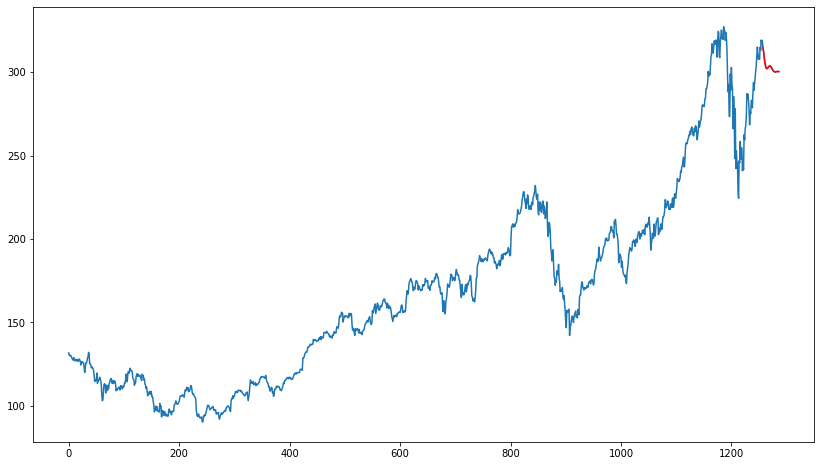

In [292]:

fig = plt.figure(figsize=(14,8))
day_pred1 = np.arange(len(df2),len(df2)+30)
plt.plot(df3)
plt.plot(day_pred1,scaler.inverse_transform(lst_output).reshape(1,-1)[0].tolist(),color='r')

1257


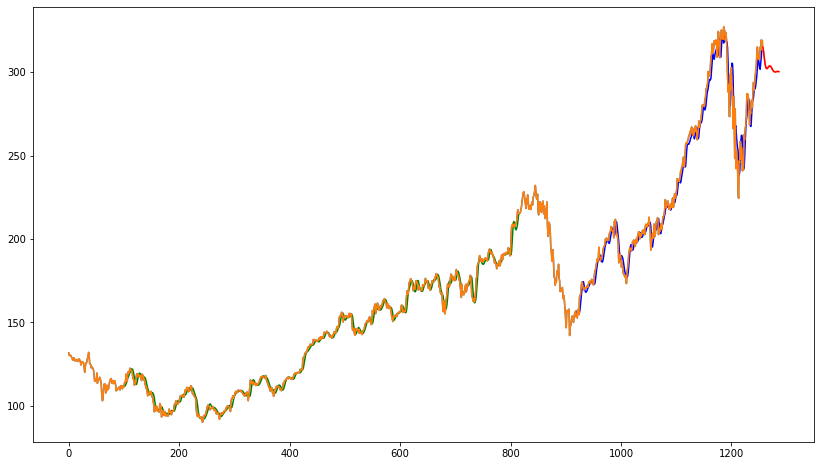

In [298]:

fig = plt.figure(figsize=(14,8))
look_back=100 #becaues time_step=100
trainpredictplot = np.empty_like(df2s)
trainpredictplot[:,:] = np.nan

trainpredictplot[look_back:len(train_predict)+look_back,:]=train_predict

testpredictplot = np.empty_like(df2s)
testpredictplot[:,:]=np.nan
print(len(testpredictplot))
testpredictplot[len(train_predict)+(look_back*2)+1:len(df2s)-1,:]=test_predict
plt.plot(scaler.inverse_transform(df2s))
plt.plot(trainpredictplot,color='g')
plt.plot(testpredictplot,color='b')
day_pred1 = np.arange(len(df2),len(df2)+30)
plt.plot(df3)
plt.plot(day_pred1,scaler.inverse_transform(lst_output).reshape(1,-1)[0].tolist(),color="r")